In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
img_height,img_width=180,180
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'dataset/',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6751 files belonging to 10 classes.
Using 5401 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'dataset/',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6751 files belonging to 10 classes.
Using 1350 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['Black', 'Blue', 'Brown', 'Green', 'Grey', 'Maroon', 'Other', 'Red', 'White', 'Yellow']


In [6]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(6):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

## Model Training using Resnet50

In [7]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=10,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(10, activation='softmax'))

In [8]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 24,641,930
Trainable params: 1,054,218
Non-trainable params: 23,587,712
_________________________________________________________________


In [9]:
resnet_model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [10]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard

In [11]:
def lr_schedule(epoch):
    if epoch < 10:
        return 1e-3
    else:
        return 1e-4

lr_scheduler = LearningRateScheduler(lr_schedule)

In [12]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard

In [13]:
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=1, 
  callbacks=[lr_scheduler]
)

169/169 [==============================] - 155s 889ms/step - loss: 0.9528 - accuracy: 0.7086 - val_loss: 0.6478 - val_accuracy: 0.7941 - lr: 0.0010


In [14]:
resnet_model.save("copy2_resnet50.h5")   ## Saving model

## Test The Model

In [15]:
loaded_model = tf.keras.models.load_model('copy2_resnet50.h5')

(1, 180, 180, 3)

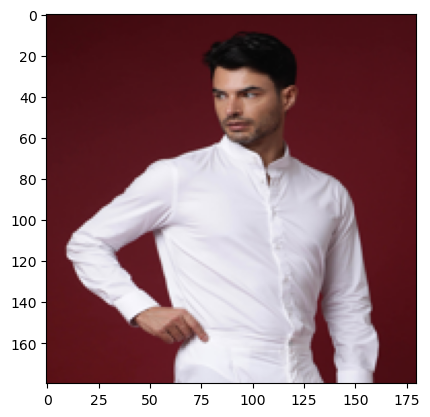

In [4]:
import cv2
import requests
from PIL import Image
from io import BytesIO
url = "https://cdn.shopify.com/s/files/1/0752/6435/products/HERO-CROP_5dcabb25-a97c-40c1-876f-1dd3fec35da3.jpg?v=1666167361"

# Download the image and open it with PIL
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = img.resize((180, 180))
plt.imshow(img)

# Convert the PIL image to a NumPy array and preprocess it
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array.shape

In [17]:
output_tensor = loaded_model(img_array)
output_tensor

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.18677966, 0.11509018, 0.00198665, 0.01700062, 0.0683267 ,
        0.16147496, 0.06507268, 0.02627592, 0.34265542, 0.01533713]],
      dtype=float32)>

In [18]:
pred=loaded_model.predict(img_array)
print(pred)

1/1 [==============================] - 1s 826ms/step
[[0.18677966 0.11509018 0.00198665 0.01700062 0.0683267  0.16147496
  0.06507268 0.02627592 0.34265542 0.01533713]]


In [19]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)

The predicted class is White
